# Test of fleGODynamic library

<IPython.core.display.Math object>

Found numpy zip archive with preparing data: psi vectors, F,M matrix. Checking if we can use it!
Checking finished. Using loaded data


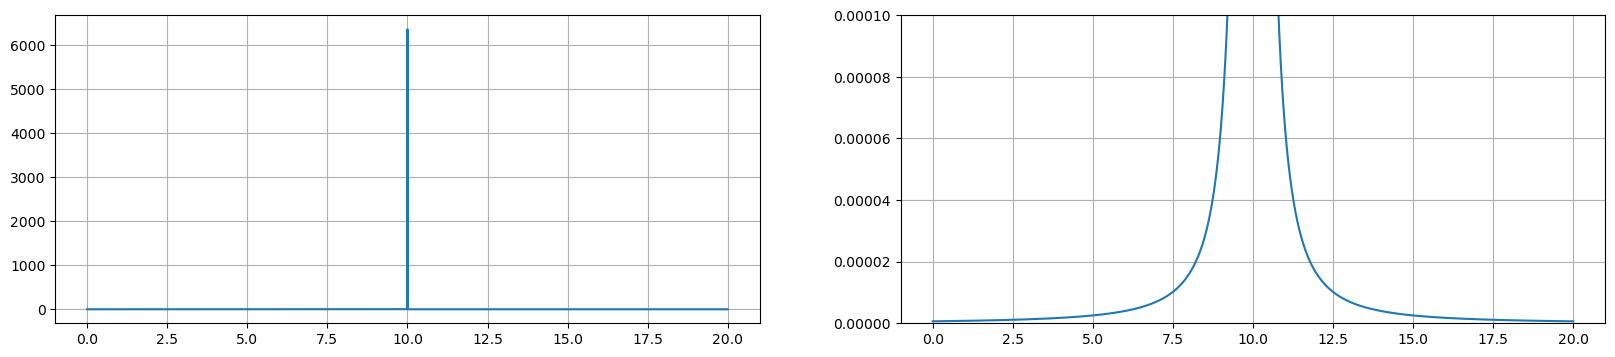

delta integral value=2.000,error=0.000000


In [231]:
import sys 
import sympy as sm
import numpy as np
# del flex_body_instance
del sys.modules["fleGODynamics"]
import fleGODynamics
flex_beam_instance = fleGODynamics.Flex_beam(L=0.02,E=2.95*1e9,h=0.01,w=0.0005)
flex_beam_instance.Create_Simulation(disp=False)
flex_beam_instance.FEM(Ne=20,disp=False)
flex_beam_instance.Simulating.Ldivide(step_mult=1,disp=True)
flex_beam_instance.Simulating.static_preparing(disp=False,Fext=2,l_Fext=0.01)

In [207]:
np.arange(0,1,1e-1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Found numpy zip archive with preparing data: psi vectors. Checking if we can use it!
Checking finished. We cannot use this data as FEM or/and Ldivide parameters mismatch. Creating new one:
Preparing time: 21.165 s
Optimization wasn't. Don't have an approximation!We will use a created by create_a fun!
evaluation time: 1.998 ms
time for 1 step: 1.996 us


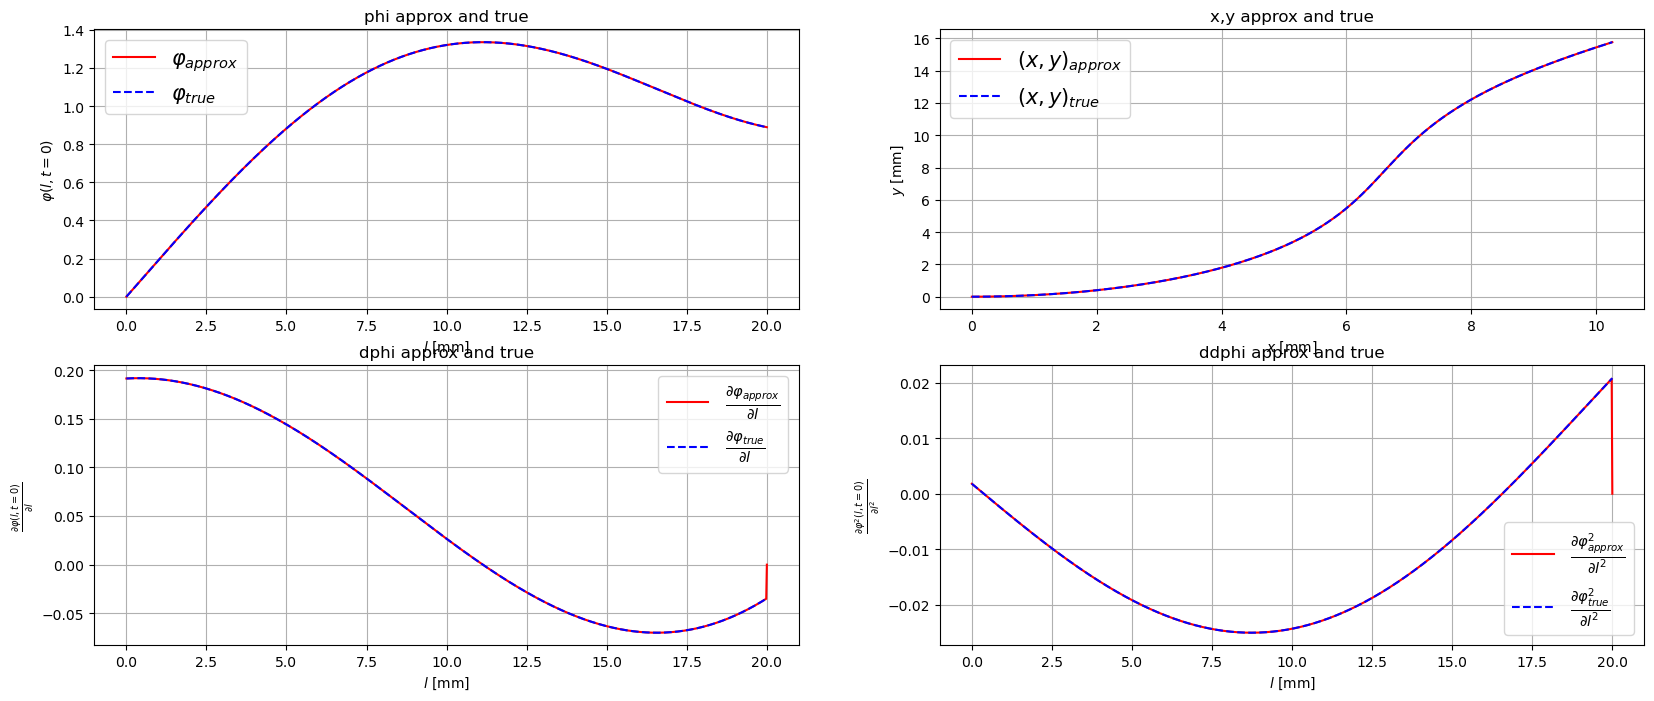

In [35]:
l = sm.symbols("l")
phi = 0.6*(1.7*sm.sin(1.7e-1*l)+0.3*(sm.exp(l/10))-0.3)
flex_beam_instance.Simulating.set_phi(phi,disp=False)
flex_beam_instance.Simulating.create_a(disp=False)
# flex_beam_instance.Simulating.show_one_element_approx(e=5)
flex_beam_instance.Simulating.phi_approx_preparing()

flex_beam_instance.Simulating.phi_approx(disp_time=True,der_num=2)

In [9]:
a = np.array([[1, 2.13412341343124134134314421124018550128903, 3, 312421342134213421344.123],[1, 2.13412341343124134134314421124018550128903, 3, 312421342134213421344.123]])
np.array2string(a)

'[[1.00000000e+00 2.13412341e+00 3.00000000e+00 3.12421342e+20]\n [1.00000000e+00 2.13412341e+00 3.00000000e+00 3.12421342e+20]]'

In [43]:
a = [1,2,3,4,5]
 
np.savetxt('Python.txt',a)
 
b = open("Python.txt").read()
b = np.array( b.split("\n")[:-1])
print( b.astype(np.float32) )

[1. 2. 3. 4. 5.]


In [2]:
import numpy as np
a = np.array([1, 2.13412341343124134134314421124018550128903, 3, 312421342134213421344.123])
            #  2.13412341343124145609522201993968
            #    123456789012345
b = np.array([1,2,3,4,5])
np.savez('test3.npz',a=a,b=b)
with np.load('test3.npz') as data:
    c = data['a']
# print(c)
# npzfile = np.load('test3.npz')
# npzfile.files
# npzfile['b']
# np.save('test3.npy', (a,b))    # .npy extension is added if not given
# d,e = np.load('test3.npy')
# print(a == d)
# print(b==e)
# print(d)
# print(e)

In [52]:
a = np.array([1, 2.13412341343124134134314421124018550128903, 3, 312421342134213421344.123])
a.tofile('test2.dat')
c = np.fromfile('test2.dat', dtype=float)
c == a
print(c)

[1.00000000e+00 2.13412341e+00 3.00000000e+00 3.12421342e+20]


In [51]:
a = np.array([1, 2.13412341343124134134314421124018550128903, 3, 312421342134213421344.123])
np.power(a,3)

array([1.00000000e+00, 9.71982826e+00, 2.70000000e+01, 3.04945396e+61])

In [85]:
a = np.array([[1,2],[3,4],[5,6]])
b = np.array([2,2,2])
c = np.array([2,3])
# np.matmul(b,a)
# np.einsum('ji,j->i', a, b)
np.multiply(b.reshape(3,1),a)
# np.sum(a,axis=0)

array([[ 2,  4],
       [ 6,  8],
       [10, 12]])

In [50]:
np.multiply( np.array([[3,4],[1,2]]),2)

array([[6, 8],
       [2, 4]])

In [ ]:

a0 = np.array([0.44584879,0.28704035,0.41002227,0.48640483,-0.02378148,0.8553858,0.08721603,0.04077981,1.01688852,0.07782734,0.02472877,1.07340978,0.09319819,0.01512953,1.08550036,0.10397254,0.01233037,1.09153201,0.11577704,0.01529716,1.08920455,0.13473095,0.03009563,1.0672586,0.12939623,0.0608087,1.13719173,0.22634223,0.11276199,1.24417473])
# a0 = np.array([0.54716727,0.14166142,0.45953198,0.73860846,-0.23974336,0.80509678,0.16614556,-0.0874239,1.04391679,0.00395172,-0.04306328,1.14646142,-0.03267354,-0.03804825,1.15281883,-0.03210473,-0.03892706,1.15139352,-0.03085558,-0.0391712,1.15120875,-0.03074385,-0.03918766,1.15120459,-0.0307429,-0.03918752,1.15120516,-0.03074331,-0.0391874,1.15120528,-0.03074348,-0.03918746,1.15120528,-0.03074343,-0.03918743,1.15120491,-0.03074355,-0.03918746,1.15119032,-0.03075098,-0.0391886,1.15106588,-0.03083216,-0.03920796,1.15170623,-0.03064048,-0.03926719,1.16539435,-0.02362461,-0.03823467,1.1873486,-0.01756641,-0.03199311,1.02898062,0.00332973,-0.01159145,1.44187508,0.48726824,0.13507458,1.17745551])
flex_beam_instance.Simulating.static(1,2e-2)

In [ ]:
str_a = np.str_( np.round(flex_beam_instance.Simulating.get_a_diff(),8)).replace('\n', ' ').replace(' ',',').replace(',,,,',',').replace(',,,',',').replace(',,',',') 
print( str_a[0] + str_a[2:])# + str_a[-1] )
# print(len(np.round(flex_beam_instance.Simulating.get_a_diff(),3)))

[0.44584879,0.28704035,0.41002227,0.48640483,-0.02378148,0.8553858,0.08721603,0.04077981,1.01688852,0.07782734,0.02472877,1.07340978,0.09319819,0.01512953,1.08550036,0.10397254,0.01233037,1.09153201,0.11577704,0.01529716,1.08920455,0.13473095,0.03009563,1.0672586,0.12939623,0.0608087,1.13719173,0.22634223,0.11276199,1.24417473]


In [ ]:
a_approx = flex_beam_instance.Simulating.get_a_approx()
# a_approx = np.array([0.,1.398054,0.522382,0.984477,-0.24426,0.254438,0.984477,-0.24426,0.254438,1.000862,-0.248743,0.255066,1.000862,-0.248743,0.255066,0.999999,-0.248574,0.255055,0.999999,-0.248574,0.255055,1.,-0.248575,0.255055,1.,-0.248575,0.255055,1.,-0.248575,0.255055,1.,-0.248575,0.255055,1.,-0.248574,0.255055,1.,-0.248574,0.255055,0.999948,-0.248585,0.255054,0.999948,-0.248585,0.255054,0.993998,-0.249492,0.254917,0.993998,-0.249492,0.254917,1.206959,-0.150128,0.269416,1.206959,-0.150128,0.269416,2.049172,1.177882,0.710173])
str_a = np.str_( np.round(a_approx,6)).replace('\n', ' ').replace(' ',',').replace(',,,,',',').replace(',,,',',').replace(',,',',') 
print( str_a[0] + str_a[2:] )
# print(len(a_approx))

[0.,-0.445849,0.28704,0.410022,0.486405,-0.023781,0.410022,0.486405,-0.023781,0.855386,0.087216,0.04078,0.855386,0.087216,0.04078,1.016889,0.077827,0.024729,1.016889,0.077827,0.024729,1.07341,0.093198,0.01513,1.07341,0.093198,0.01513,1.0855,0.103973,0.01233,1.0855,0.103973,0.01233,1.091532,0.115777,0.015297,1.091532,0.115777,0.015297,1.089205,0.134731,0.030096,1.089205,0.134731,0.030096,1.067259,0.129396,0.060809,1.067259,0.129396,0.060809,1.137192,0.226342,0.112762,1.137192,0.226342,0.112762,1.244175,0.,0.,]


In [ ]:
flex_beam_instance.Simulating.set_a_approx(a_approx)

Optimization wasn't. Don't have a approximation!
evaluation time:220.0 ms
time for 1 step:220.0 us


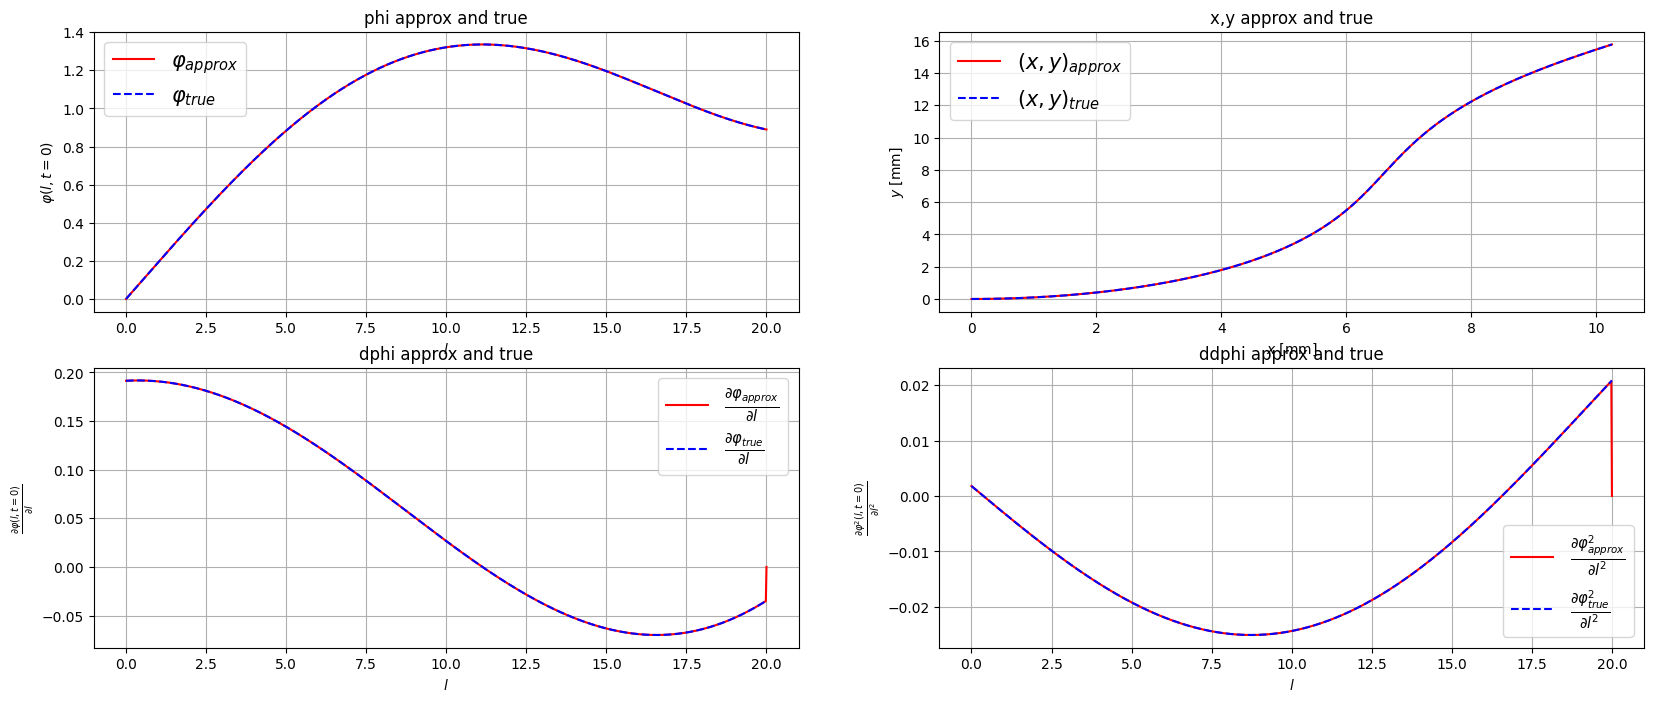

In [ ]:
flex_beam_instance.Simulating.phi_approx(disp_time=True,der_num=2)